In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA,ARMA
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error

# Ice Cream Production Data

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#read data
df_ice_cream = pd.read_csv('/content/drive/MyDrive/Advanced_Machine_Learning/Time_Series_Analysis/Time-Series-Analysis-master/ice_cream.csv')

In [28]:
df_ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [29]:
#rename columns to something more understandable
df_ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

In [30]:
#convert date column to datetime type
df_ice_cream['date'] = pd.to_datetime(df_ice_cream.date)

In [31]:
#set date as index
df_ice_cream.set_index('date', inplace=True)

In [32]:
df_ice_cream = df_ice_cream.asfreq(pd.infer_freq(df_ice_cream.index))

In [33]:
#just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
df_ice_cream = df_ice_cream[start_date:]

In [34]:
#show result
df_ice_cream.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


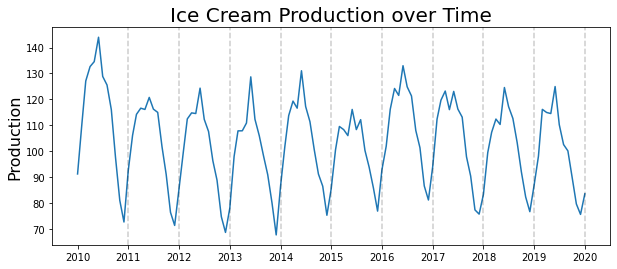

In [35]:
plt.figure(figsize=(10,4))
plt.plot(df_ice_cream.production)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# ACF

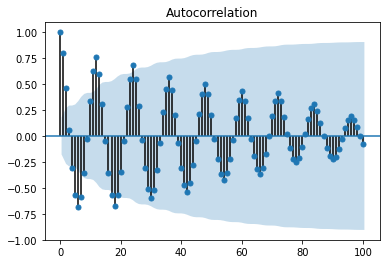

In [36]:
acf_plot = plot_acf(df_ice_cream.production, lags=100)

## Based on decaying ACF, we are likely dealing with an Auto Regressive process

# PACF

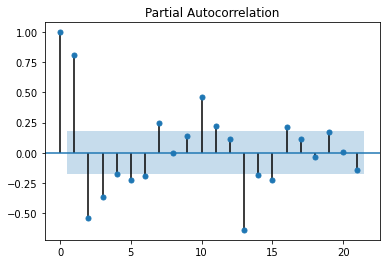

In [37]:
pacf_plot = plot_pacf(df_ice_cream.production)

## Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 3, 10, 13

# Train and test set splits

In [77]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)
train_data = df_ice_cream[:train_end]
test_data = df_ice_cream[train_end + timedelta(days = 1):test_end]

# Fit and AR model

In [90]:
#create a model
model = ARMA(train_data,order = (7,0))

In [91]:
start = time()
model_fit = model.fit()
end = time()
print('Modle Fitting Time:',end - start)


Modle Fitting Time: 0.8785133361816406


In [92]:
# summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                   84
Model:                     ARMA(7, 0)   Log Likelihood                -281.536
Method:                       css-mle   S.D. of innovations              6.732
Date:                Thu, 08 Dec 2022   AIC                            581.073
Time:                        13:31:10   BIC                            602.950
Sample:                    01-01-2010   HQIC                           589.867
                         - 12-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5531      1.390     74.507      0.000     100.829     106.277
ar.L1.production     0.9546      0.103      9.288      0.000       0.753       1.156
ar.L2.production    -0.1185 

In [93]:
# get prediction start and end dates

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [94]:
predictions = model_fit.predict(start = pred_start_date,end = pred_end_date)
residuals = test_data['production'] - predictions

In [95]:
residuals

date
2017-01-01    10.688250
2017-02-01    24.258646
2017-03-01    21.036156
2017-04-01    17.735029
2017-05-01     0.275457
2017-06-01     1.988516
2017-07-01    -5.025720
2017-08-01    -4.433732
2017-09-01   -11.376250
2017-10-01   -11.920519
2017-11-01   -16.945093
2017-12-01   -13.823428
2018-01-01    -5.048192
2018-02-01     8.463078
2018-03-01     9.957583
2018-04-01     8.685769
2018-05-01    -0.073109
2018-06-01     9.873880
2018-07-01     1.024740
2018-08-01    -1.851133
2018-09-01    -6.473263
2018-10-01   -12.100706
2018-11-01   -16.093728
2018-12-01   -17.846683
2019-01-01    -5.987964
2019-02-01     4.090357
2019-03-01    18.599784
2019-04-01    12.748092
2019-05-01     7.473951
2019-06-01    14.291539
2019-07-01    -2.086963
2019-08-01    -9.181157
2019-09-01    -8.957040
2019-10-01   -15.143909
2019-11-01   -21.469044
2019-12-01   -22.249816
Freq: MS, dtype: float64

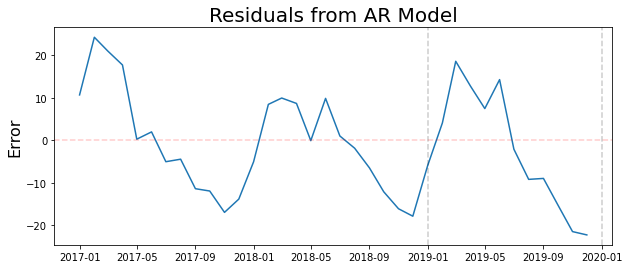

In [96]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model',fontsize = 20)
plt.ylabel('Error',fontsize = 16)
plt.axhline(0,color = 'r',linestyle = '--',alpha = 0.2)
for year in range(2019,2021):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'),color = 'k',linestyle = '--',alpha = 0.2)


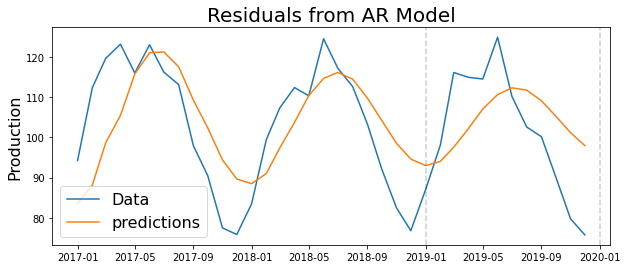

In [97]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data',"predictions"),fontsize = 16)
plt.title('Residuals from AR Model',fontsize = 20)
plt.ylabel('Production',fontsize = 16)
for year in range(2019,2021):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'),color = 'k',linestyle = '--',alpha = 0.2)


In [98]:
#mean_absolute_percentage_error
print('Mean Absolute Percent Error: ', mean_absolute_percentage_error(test_data,predictions))

Mean Absolute Percent Error:  0.109206991564616


In [99]:
print('Root Mean Squared Error : ',np.sqrt(mean_squared_error(test_data,predictions)))

Root Mean Squared Error :  12.442457746003955


# Rolling Forecast Origin

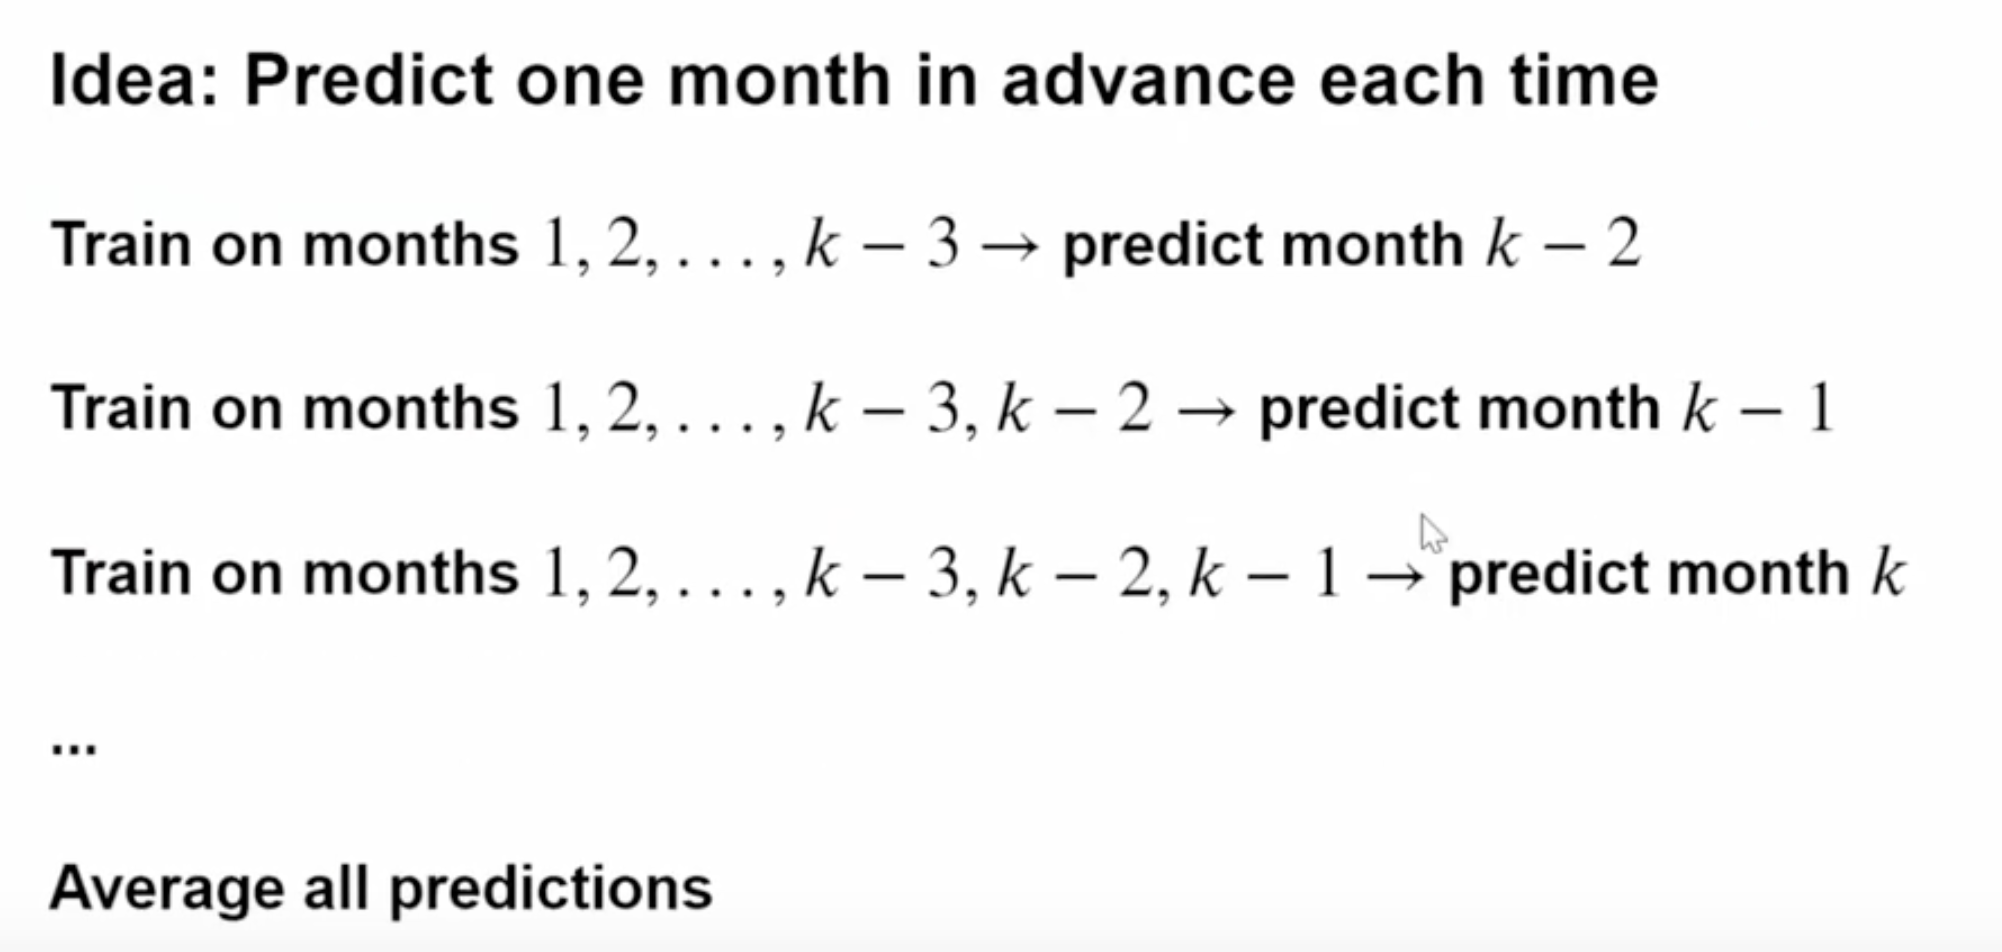

In [102]:
# create the model
predicitons_rolling = pd.Series()
for end_date in test_data.index:
  train_data = df_ice_cream[:end_date - timedelta(days =1)]
  model = ARMA(train_data,order = (3,0))
  model_fit = model.fit()
  pred = model_fit.predict(end_date)
  predicitons_rolling.loc[end_date] = pred.loc[end_date]

In [105]:
residuals_rolling = test_data['production'] - predicitons_rolling

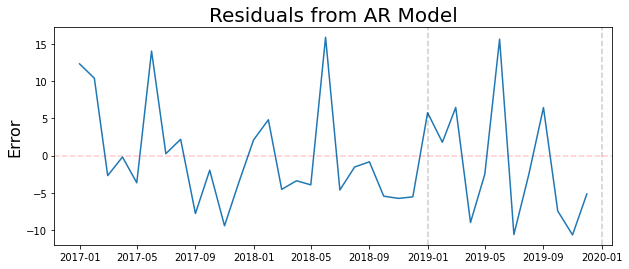

In [106]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model',fontsize = 20)
plt.ylabel('Error',fontsize = 16)
plt.axhline(0,color = 'r',linestyle = '--',alpha = 0.2)
for year in range(2019,2021):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'),color = 'k',linestyle = '--',alpha = 0.2)


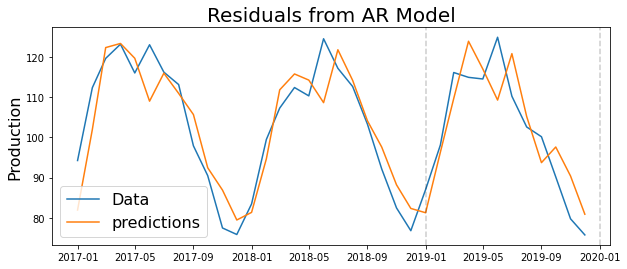

In [107]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predicitons_rolling)
plt.legend(('Data',"predictions"),fontsize = 16)
plt.title('Residuals from AR Model',fontsize = 20)
plt.ylabel('Production',fontsize = 16)
for year in range(2019,2021):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'),color = 'k',linestyle = '--',alpha = 0.2)


In [108]:
#mean_absolute_percentage_error
print('Mean Absolute Percent Error: ', mean_absolute_percentage_error(test_data,predicitons_rolling))

Mean Absolute Percent Error:  0.05815882843740391


In [109]:
print('Root Mean Squared Error : ',np.sqrt(mean_squared_error(test_data,predicitons_rolling)))

Root Mean Squared Error :  7.196554738591428
